In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from Bio import PDB

# Load Ground truth

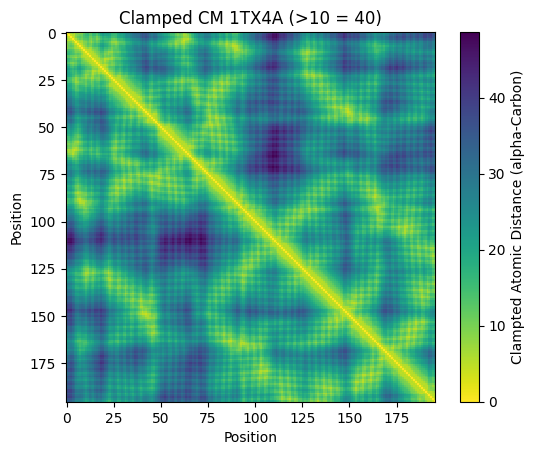

In [46]:

def calculate_contact_map_binary(pdb_file, cutoff=8.0):
    # Initialize parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get alpha carbon atoms
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    ca_atoms.append(residue["CA"])

    # Get sequence length
    sequence_length = len(ca_atoms)
    
    # Initialize contact map
    contact_map = np.zeros((sequence_length, sequence_length), dtype=int)
    
    # Calculate distances and populate contact map
    for i in range(sequence_length):
        for j in range(i + 1, sequence_length):
            distance = ca_atoms[i] - ca_atoms[j]
            if distance <= cutoff:
                contact_map[i, j] = 1
                contact_map[j, i] = 1  # Symmetric matrix

    return contact_map

def calculate_distance_map(pdb_file):
    # Initialize parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get alpha carbon atoms
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    ca_atoms.append(residue["CA"])

    # Get sequence length
    sequence_length = len(ca_atoms)
    
    # Initialize distance map
    distance_map = np.zeros((sequence_length, sequence_length), dtype=float)
    
    # Calculate distances and populate distance map
    for i in range(sequence_length):
        for j in range(i + 1, sequence_length):
            distance = ca_atoms[i] - ca_atoms[j]
            distance_map[i, j] = distance
            distance_map[j, i] = distance  # Symmetric matrix

    return distance_map

# Path to your uploaded PDB file
pdb_file_path = '1TX4_A.pdb'
contact_map_ground_truth = calculate_distance_map(pdb_file_path)

# Map values above 20 to 40
threshold_value = 20
new_value = 40
mapped_matrix = np.where(contact_map_ground_truth > threshold_value, new_value, contact_map_ground_truth)
# plt.figure(figsize=(8, 8))
plt.imshow(contact_map_ground_truth, cmap="viridis_r", interpolation="nearest")
plt.colorbar(label="Clampted Atomic Distance (alpha-Carbon)")
plt.title("Clamped CM 1TX4A (>10 = 40)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()


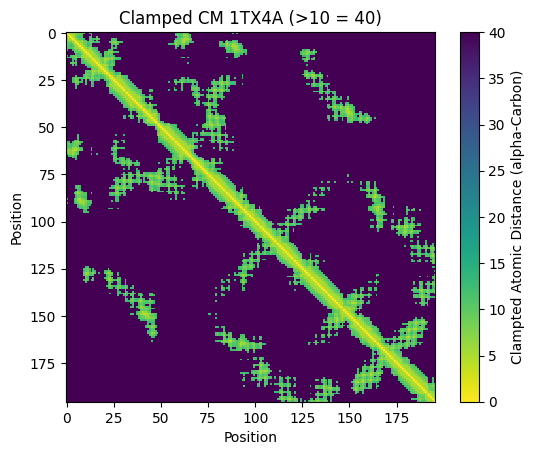

In [85]:
# Map values above 20 to 40
threshold_value = 13
new_value = 40
mapped_matrix = np.where(contact_map_ground_truth > threshold_value, new_value, contact_map_ground_truth)

plt.imshow(mapped_matrix, cmap="viridis_r", interpolation="nearest")
plt.colorbar(label="Clampted Atomic Distance (alpha-Carbon)")
plt.title("Clamped CM 1TX4A (>10 = 40)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

# Load Predicted Matrix

In [86]:
# Open the HDF5 file in read mode
file_path = 'out/1TX4-A_esm2_t33_650M_UR50D.h5'  # replace with your file path
with h5py.File(file_path, 'r') as h5_file:    
    # Access a specific dataset
    dataset = h5_file['1TX4-A']  # replace with your dataset name
    contact_map = dataset[:]


In [87]:
def contact_map_to_distances(contact_map, n_bins=30, min_dist=0.01, max_dist=50.0):
    """
    Convert a contact map to binned distances
    
    Parameters:
    -----------
    contact_map : np.ndarray
        2D numpy array of contact probabilities (L x L)
    n_bins : int
        Number of distance bins to use
    min_dist : float
        Minimum distance in Angstroms
    max_dist : float
        Maximum distance in Angstroms
        
    Returns:
    --------
    distances : np.ndarray
        LxL matrix of predicted distances (mean of most likely bin)
    distance_probs : np.ndarray
        LxLxB tensor of probabilities for each distance bin
    bin_edges : np.ndarray
        Array of bin boundaries
    """
    # Create distance bins
    bin_edges = np.linspace(min_dist, max_dist, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Convert contact probabilities to distance probabilities
    L = contact_map.shape[0]
    distance_probs = np.zeros((L, L, n_bins))
    
    # For each position pair
    for i in range(L):
        for j in range(L):
            if i != j:
                contact_prob = contact_map[i,j]
                
                # If high contact probability, concentrate around typical Cβ-Cβ distance (8Å)
                if contact_prob > 0.5:
                    mu = 8.0  # typical Cβ-Cβ distance for contacts
                    sigma = 4.0 * (1 - contact_prob)  # uncertainty scales with 1-prob
                else:
                    mu =30.0  # typical non-contact distance
                    sigma = 4.0
                
                # Create gaussian distribution over bins
                bin_probs = np.exp(-0.5 * ((bin_centers - mu)/sigma)**2)
                bin_probs = bin_probs / bin_probs.sum()  # normalize
                
                distance_probs[i,j] = bin_probs
    
    # Get mean distance prediction (weighted average of bin centers)
    distances = np.sum(bin_centers[None,None,:] * distance_probs, axis=2)
    
    # Make symmetric
    distances = (distances + distances.T) / 2
    distance_probs = (distance_probs + np.transpose(distance_probs, (1,0,2))) / 2
    
    return distances, distance_probs, bin_edges

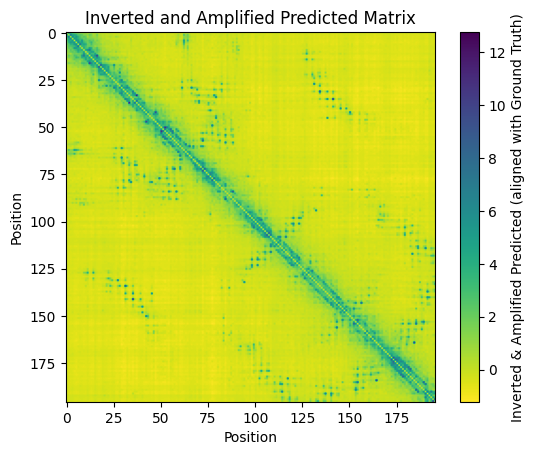

In [88]:
# Plot the result
plt.imshow(contact_map, cmap="viridis_r")
plt.colorbar(label="Inverted & Amplified Predicted (aligned with Ground Truth)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.title("Inverted and Amplified Predicted Matrix")
# plt.savefig(f"amplified_test/map_{af}_{max_gt}")
# plt.clf()
plt.show()

/var/folders/1r/d8n6pptn3637m2x69yyhsn4h0000gn/T/ipykernel_10244/523077086.py:49: RuntimeWarning: invalid value encountered in divide
  bin_probs = bin_probs / bin_probs.sum()  # normalize


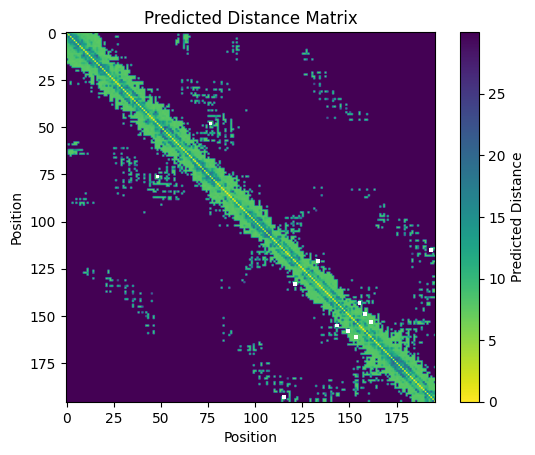

In [89]:
distance = contact_map_to_distances(contact_map)
plt.imshow(distance[0], cmap="viridis_r")
plt.colorbar(label="Predicted Distance")
plt.xlabel("Position")
plt.ylabel("Position")
plt.title("Predicted Distance Matrix")
plt.show()



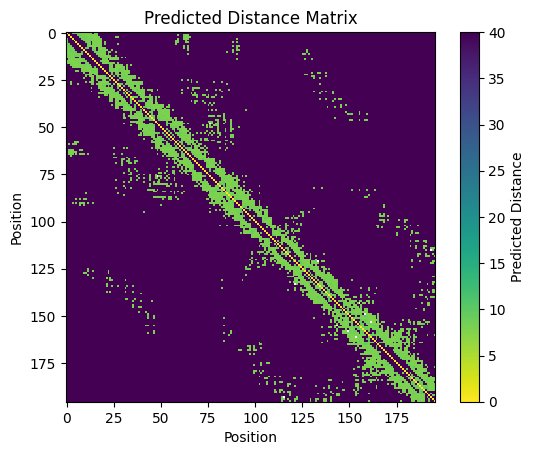

In [80]:
mapped_matrix_predict = np.where(distance[0] > threshold_value, new_value, distance[0])

plt.imshow(mapped_matrix_predict, cmap="viridis_r", interpolation="nearest")
plt.colorbar(label="Predicted Distance")
plt.xlabel("Position")
plt.ylabel("Position")
plt.title("Predicted Distance Matrix")
plt.show()

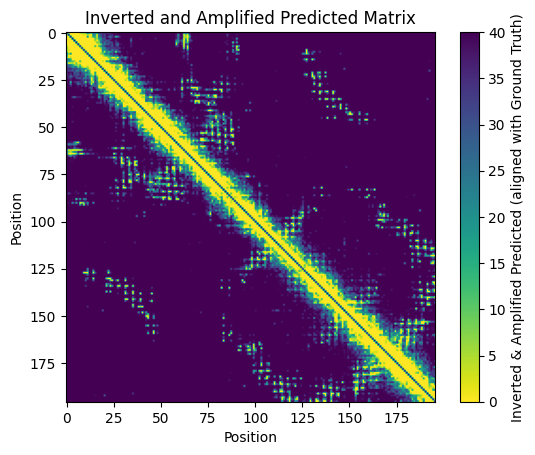

In [10]:

# Amplify the predicted matrix (you can adjust the factor as needed)
amplification_factor = 30 # Value more or less arbitrary right now
amplified_predicted_matrix = contact_map * amplification_factor

# Invert the amplified matrix valu40es to match the ground truth range
max_ground_truth = 40 # Value more or less arbitrary right now
inverted_amplified_matrix = max_ground_truth - amplified_predicted_matrix

# Clip values to avoid negative numbers if necessary
inverted_amplified_matrix = np.clip(inverted_amplified_matrix, 0, max_ground_truth)

# Plot the result
plt.imshow(inverted_amplified_matrix, cmap="viridis_r")
plt.colorbar(label="Inverted & Amplified Predicted (aligned with Ground Truth)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.title("Inverted and Amplified Predicted Matrix")
# plt.savefig(f"amplified_test/map_{af}_{max_gt}")
# plt.clf()
plt.show()

# Calculate IDDT

In [51]:
import numpy as np

def calculate_iddt(matrix_A, matrix_B, threshold=8.0, tolerance=2.0):
    # Step 1: Convert to binary contact matrices based on threshold
    contact_A = (matrix_A < threshold).astype(int)
    contact_B = (matrix_B < threshold).astype(int)
    
    # Step 2: Calculate absolute differences
    absolute_differences = np.abs(matrix_A - matrix_B)

    # Step 3: Calculate IDDT scores for each contact
    iddt_scores = np.where(absolute_differences <= tolerance, 1, 0)
    
    # Step 4: Calculate the average IDDT score
    iddt_score = np.sum(iddt_scores) / (matrix_A.shape[0] * matrix_A.shape[1])
    
    return iddt_score

iddt = calculate_iddt(distance[0], contact_map_ground_truth)
iddt_mapped = calculate_iddt(distance[0], mapped_matrix)
print("IDDT Score:", iddt, iddt_mapped)


IDDT Score: 0.19648063306955435 0.11682632236568097


In [52]:
import numpy as np

def calculate_iddt(dist_observed, dist_predicted, thresholds=[0.5, 1, 2, 4]):
    """
    Calculate IDDT score between observed and predicted distance matrices
    
    Parameters:
    -----------
    dist_observed : np.ndarray
        LxL matrix of observed distances
    dist_predicted : np.ndarray
        LxL matrix of predicted distances
    thresholds : list
        Distance difference thresholds in Angstroms
        
    Returns:
    --------
    float
        IDDT score (between 0 and 1)
    """
    if dist_observed.shape != dist_predicted.shape:
        raise ValueError("Observed and predicted distance matrices must have same shape")
    
    L = dist_observed.shape[0]
    scores = []
    
    # Create mask for valid distances (excluding diagonal and possibly invalid values)
    mask = np.ones((L, L), dtype=bool)
    np.fill_diagonal(mask, False)
    mask = mask & ~np.isnan(dist_observed) & ~np.isnan(dist_predicted)
    
    # Calculate absolute differences
    diff_matrix = np.abs(dist_observed - dist_predicted)
    
    # Calculate scores for each threshold
    for threshold in thresholds:
        # Count pairs within threshold
        within_threshold = (diff_matrix <= threshold) & mask
        score = np.sum(within_threshold) / np.sum(mask)
        scores.append(score)
    
    # IDDT is average over all thresholds
    iddt_score = np.mean(scores)
    
    return iddt_score

# You can also get per-residue IDDT scores
def calculate_per_residue_iddt(dist_observed, dist_predicted, thresholds=[0.5, 1, 2, 4]):
    """
    Calculate per-residue IDDT scores
    
    Parameters:
    -----------
    dist_observed : np.ndarray
        LxL matrix of observed distances
    dist_predicted : np.ndarray
        LxL matrix of predicted distances
    thresholds : list
        Distance difference thresholds in Angstroms
        
    Returns:
    --------
    np.ndarray
        Array of per-residue IDDT scores
    """
    L = dist_observed.shape[0]
    per_residue_scores = np.zeros(L)
    
    # Create mask for valid distances
    mask = np.ones((L, L), dtype=bool)
    np.fill_diagonal(mask, False)
    mask = mask & ~np.isnan(dist_observed) & ~np.isnan(dist_predicted)
    
    # Calculate absolute differences
    diff_matrix = np.abs(dist_observed - dist_predicted)
    
    # Calculate per-residue scores
    for i in range(L):
        residue_scores = []
        for threshold in thresholds:
            # Count pairs within threshold for this residue
            within_threshold = (diff_matrix[i] <= threshold) & mask[i]
            score = np.sum(within_threshold) / np.sum(mask[i])
            residue_scores.append(score)
        per_residue_scores[i] = np.mean(residue_scores)
    
    return per_residue_scores


# Calculate global IDDT
iddt_score = calculate_iddt(mapped_matrix, distance[0])
print(f"Global IDDT score: {iddt_score}")

# Calculate per-residue IDDT
per_residue_scores = calculate_per_residue_iddt(mapped_matrix, distance[0])
print(f"Average per-residue IDDT score: {np.mean(per_residue_scores)}")
print(f"Per-residue score range: {np.min(per_residue_scores)} - {np.max(per_residue_scores)}")

Global IDDT score: 0.10540986180904523
Average per-residue IDDT score: 0.10541297803816214
Per-residue score range: 0.03974358974358974 - 0.1948717948717949


# Maybe other metrics

In [93]:
import numpy as np
from scipy import stats
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_protein_metrics(dist_observed, dist_predicted):
    """
    Calculate various protein structural metrics from distance matrices
    
    Parameters:
    -----------
    dist_observed : np.ndarray
        LxL matrix of observed distances
    dist_predicted : np.ndarray
        LxL matrix of predicted distances
    
    Returns:
    --------
    dict
        Dictionary containing various metrics
    """
    metrics = {}
    
    # Remove diagonal and get valid indices
    mask = ~np.eye(dist_observed.shape[0], dtype=bool)
    valid_mask = mask & ~np.isnan(dist_observed) & ~np.isnan(dist_predicted)
    
    obs_flat = dist_observed[valid_mask]
    pred_flat = dist_predicted[valid_mask]
    
    # 1. Basic Distance Metrics
    metrics['rmsd'] = np.sqrt(np.mean((obs_flat - pred_flat)**2))
    metrics['mae'] = np.mean(np.abs(obs_flat - pred_flat))
    
    # 2. Correlations
    metrics['pearson'] = stats.pearsonr(obs_flat, pred_flat)[0]
    metrics['spearman'] = stats.spearmanr(obs_flat, pred_flat)[0]
    
    # 3. Contact-based metrics at different thresholds
    thresholds = [1.0, 5.0, 10.0, 15.0]  # Common contact thresholds in Angstroms
    for threshold in thresholds:
        obs_contacts = dist_observed <= threshold
        pred_contacts = dist_predicted <= threshold
        
        # Calculate metrics for this threshold
        metrics[f'precision_{threshold}A'] = precision_score(
            obs_contacts[valid_mask], 
            pred_contacts[valid_mask]
        )
        metrics[f'recall_{threshold}A'] = recall_score(
            obs_contacts[valid_mask], 
            pred_contacts[valid_mask]
        )
        metrics[f'f1_{threshold}A'] = f1_score(
            obs_contacts[valid_mask], 
            pred_contacts[valid_mask]
        )
    
    # 4. Distance ranges analysis
    ranges = [(0, 8), (8, 15), (15, 30), (30, float('inf'))]
    for start, end in ranges:
        obs_range = (dist_observed >= start) & (dist_observed < end)
        pred_range = (dist_predicted >= start) & (dist_predicted < end)
        
        if np.sum(obs_range[valid_mask]) > 0:  # Avoid division by zero
            metrics[f'accuracy_{start}_{end}A'] = np.sum(
                (obs_range & pred_range)[valid_mask]
            ) / np.sum(obs_range[valid_mask])
    
    # 5. Per-residue accuracy
    L = dist_observed.shape[0]
    per_residue_rmsd = np.zeros(L)
    for i in range(L):
        valid_i = valid_mask[i]
        if np.sum(valid_i) > 0:
            per_residue_rmsd[i] = np.sqrt(np.mean(
                (dist_observed[i, valid_i] - dist_predicted[i, valid_i])**2
            ))
    metrics['per_residue_rmsd'] = per_residue_rmsd
    metrics['worst_residue_rmsd'] = np.max(per_residue_rmsd)
    metrics['best_residue_rmsd'] = np.min(per_residue_rmsd)
    
    return metrics

def print_metric_analysis(metrics):
    """Pretty print the metrics with interpretations"""
    print("\nProtein Structure Prediction Metrics:")
    print("-" * 50)
    
    print("\nGlobal Distance Metrics:")
    print(f"RMSD: {metrics['rmsd']:.3f} Å")
    print(f"MAE: {metrics['mae']:.3f} Å")
    
    print("\nCorrelations:")
    print(f"Pearson: {metrics['pearson']:.3f}")
    print(f"Spearman: {metrics['spearman']:.3f}")
    
    print("\nContact Metrics at Different Thresholds:")
    for threshold in [1.0, 5.0, 10.0, 15.0]:
        print(f"\nAt {threshold}Å threshold:")
        print(f"  Precision: {metrics[f'precision_{threshold}A']:.3f}")
        print(f"  Recall: {metrics[f'recall_{threshold}A']:.3f}")
        print(f"  F1-score: {metrics[f'f1_{threshold}A']:.3f}")
    
    print("\nDistance Range Accuracies:")
    ranges = [(0, 8), (8, 15), (15, 30), (30, float('inf'))]
    for start, end in ranges:
        key = f'accuracy_{start}_{end}A'
        if key in metrics:
            print(f"{start}-{end}Å: {metrics[key]:.3f}")
    
    print("\nPer-Residue Analysis:")
    print(f"Best Residue RMSD: {metrics['best_residue_rmsd']:.3f} Å")
    print(f"Worst Residue RMSD: {metrics['worst_residue_rmsd']:.3f} Å")


    # Calculate metrics
metrics = calculate_protein_metrics(mapped_matrix,contact_map)
    
    # Print analysis
print_metric_analysis(metrics)


Protein Structure Prediction Metrics:
--------------------------------------------------

Global Distance Metrics:
RMSD: 36.882 Å
MAE: 34.789 Å

Correlations:
Pearson: -0.667
Spearman: -0.528

Contact Metrics at Different Thresholds:

At 1.0Å threshold:
  Precision: 0.000
  Recall: 0.000
  F1-score: 0.000

At 5.0Å threshold:
  Precision: 0.008
  Recall: 0.696
  F1-score: 0.017

At 10.0Å threshold:
  Precision: 0.085
  Recall: 0.996
  F1-score: 0.156

At 15.0Å threshold:
  Precision: 0.171
  Recall: 1.000
  F1-score: 0.292

Distance Range Accuracies:
0-8Å: 0.950
8-15Å: 0.002
30-infÅ: 0.000

Per-Residue Analysis:
Best Residue RMSD: 34.571 Å
Worst Residue RMSD: 39.063 Å


/opt/miniconda3/envs/pp2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [94]:
    # Calculate metrics
metrics = calculate_protein_metrics(mapped_matrix,distance[0])
    
    # Print analysis
print_metric_analysis(metrics)


Protein Structure Prediction Metrics:
--------------------------------------------------

Global Distance Metrics:
RMSD: 12.022 Å
MAE: 10.826 Å

Correlations:
Pearson: 0.596
Spearman: 0.615

Contact Metrics at Different Thresholds:

At 1.0Å threshold:
  Precision: 0.000
  Recall: 0.000
  F1-score: 0.000

At 5.0Å threshold:
  Precision: 0.000
  Recall: 0.000
  F1-score: 0.000

At 10.0Å threshold:
  Precision: 0.363
  Recall: 0.452
  F1-score: 0.403

At 15.0Å threshold:
  Precision: 0.714
  Recall: 0.529
  F1-score: 0.608

Distance Range Accuracies:
0-8Å: 0.065
8-15Å: 0.255
30-infÅ: 0.000

Per-Residue Analysis:
Best Residue RMSD: 10.132 Å
Worst Residue RMSD: 13.979 Å


/opt/miniconda3/envs/pp2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/pp2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/pp2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/pp2/lib/pyt